In [1]:
# data from FoodData Central: https://fdc.nal.usda.gov/
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read subset of food nutrient csv
nutrient = pd.read_csv('./data_csvs/food_nutrient.csv', usecols=['fdc_id', 'nutrient_id', 'amount'])

print('dataframe shape:', nutrient.shape)
nutrient.head()

dataframe shape: (26235966, 3)


,fdc_id,nutrient_id,amount
0,1105904,1257,0.00
1,1105904,1293,53.33
2,1105904,1253,0.00
3,1105904,1092,0.00
4,1105904,1008,867.00


In [3]:
# read subset of nutrient csv
nutrient_id = pd.read_csv('./data_csvs/nutrient.csv', usecols=['id', 'name', 'unit_name'])

print('dataframe shape:', nutrient_id.shape)
nutrient_id.head()

dataframe shape: (477, 3)


,id,name,unit_name
0,2047,Energy (Atwater General Factors),KCAL
1,2048,Energy (Atwater Specific Factors),KCAL
2,1001,Solids,G
3,1002,Nitrogen,G
4,1003,Protein,G


In [4]:
# duplicate id to double check that ids from both tables match
nutrient_id['id2'] = nutrient_id['id']

# join nutrients with nutrient names, etc
food_nutrients = nutrient.join(
    nutrient_id.set_index('id'), on='nutrient_id', how='left')

food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2
0,1105904,1257,0.00,"Fatty acids, total trans",G,1257.0
1,1105904,1293,53.33,"Fatty acids, total polyunsaturated",G,1293.0
2,1105904,1253,0.00,Cholesterol,MG,1253.0
3,1105904,1092,0.00,"Potassium, K",MG,1092.0
4,1105904,1008,867.00,Energy,KCAL,1008.0


In [5]:
# load branded food dataframe
branded_food = pd.read_csv('cleaned_branded_food.csv')

In [6]:
# want nutrients for foods in branded food dataframe
# get fdc ids from food nutrients dataframe that are not in branded food df
bf = set(branded_food['fdc_id'])
fn = set(food_nutrients['fdc_id'])
diff = fn - bf

print("number of fdc ids in food nutrients df that aren't in branded food df:\n", len(diff))

number of fdc ids in food nutrients df that aren't in branded food df:
 768312


In [7]:
# make boolean to indicate fdc ids not in branded food df
keeprows = [True if fdcid not in diff else False for fdcid in food_nutrients['fdc_id']]

# drop fdc ids that aren't also in branded food dataframe
food_nutrients = food_nutrients[keeprows]

print('food nutrients shape after dropping fdc ids: ', food_nutrients.shape)

food nutrients shape after dropping fdc ids:  (16099046, 6)


In [8]:
print('num unique fdc ids:', len(food_nutrients['fdc_id'].unique()))

num unique fdc ids: 1137369


In [9]:
# check for nans after combining nutrient dataframes and dropping fdc ids not in branded food dataframe
food_nutrients.isna().sum()

fdc_id         0
nutrient_id    0
amount         0
name           0
unit_name      0
id2            0
dtype: int64

In [10]:
# check if nutrients have duplicates 
countnutrientid = food_nutrients.groupby('fdc_id')['nutrient_id'].value_counts()
duplicates = countnutrientid[countnutrientid > 1]

print('average number of repetition:', np.mean(duplicates))
duplicates

average number of repetition: 2.0284718187100523


fdc_id   nutrient_id
2456687  1008           2
2456691  1008           2
2456693  1008           2
2456695  1008           2
2456699  1008           2
                       ..
2641378  2000           2
2641422  1079           2
2641423  1079           2
2641427  1162           2
2643369  2000           2
Name: count, Length: 1721, dtype: int64

In [11]:
# check ingredients of some fdc ids with duplicates
# food_nutrients[food_nutrients['fdc_id']==2456687]
# food_nutrients[food_nutrients['fdc_id']==2641378]
food_nutrients[food_nutrients['fdc_id']==2641423]

,fdc_id,nutrient_id,amount,name,unit_name,id2
26002560,2641423,1003,16.07,Protein,G,1003.0
26002561,2641423,1005,3.57,"Carbohydrate, by difference",G,1005.0
26002562,2641423,1004,5.36,Total lipid (fat),G,1004.0
26002563,2641423,1079,0.00,"Fiber, total dietary",G,1079.0
26002564,2641423,2067,0.00,Vitamin A,UG,2067.0
26002565,2641423,1089,0.64,"Iron, Fe",MG,1089.0
26002566,2641423,1258,0.89,"Fatty acids, total saturated",G,1258.0
26002567,2641423,1008,125.00,Energy,KCAL,1008.0
26002568,2641423,1079,0.00,"Fiber, total dietary",G,1079.0
26002569,2641423,1162,26.80,"Vitamin C, total ascorbic acid",MG,1162.0


In [12]:
# duplicate nutrient id entries have the same 'amount' values or low values that look abnormally low
# for duplicate nutrient id entries, keep higher 'amount' value
# iterate through duplicates
idxs_todrop = []
for fdcid, nutid in duplicates.index:
    # matches fdc id
    matchfdc = food_nutrients[food_nutrients['fdc_id']==fdcid]
    # matches fdc id and nutrient id
    matches = matchfdc[matchfdc['nutrient_id']==nutid]
    # list of match indicies
    matchidxs = matches.index
    
    # if amounts all the same, drop all but the first
    if np.mean(matches['amount']) == matches.loc[matchidxs[0], 'amount']:
        todrop = list(matchidxs[1:])
    # else amounts different, keep the highest value
    else:
        # largest value
        largestamt = np.max(matches['amount'])
        todrop = [matchidxs[i] for i in range(len(matchidxs)) if matches.loc[matchidxs[i], 'amount'] < largestamt]
        
    # add indexes to list
    idxs_todrop += todrop

print('num indexs to drop:', len(idxs_todrop))
idxs_todrop[:5]

num indexs to drop: 1770


[23329252, 23329310, 23329327, 23329366, 23329420]

In [13]:
print('original shape: ', food_nutrients.shape)

# drop duplicate nutrient rows
food_nutrients.drop(idxs_todrop, axis=0, inplace=True)

print('duplicates dropped shape:', food_nutrients.shape)

original shape:  (16099046, 6)
duplicates dropped shape: (16097276, 6)


In [14]:
# check if nutrient names have duplicates 
countnutrientid = food_nutrients.groupby('fdc_id')['name'].value_counts()
duplicates = countnutrientid[countnutrientid > 1]

print('average number of repetition:', np.mean(duplicates))
duplicates

average number of repetition: 2.0


fdc_id   name  
398115   Energy    2
454151   Energy    2
510967   Energy    2
559122   Energy    2
1207913  Energy    2
1259053  Energy    2
1309465  Energy    2
1499968  Energy    2
1551120  Energy    2
1601579  Energy    2
2031320  Energy    2
2062075  Energy    2
2092058  Energy    2
2334505  Energy    2
2339503  Energy    2
2439555  Energy    2
Name: count, dtype: int64

In [15]:
# energy given in kJ (nutrient id 1062) as well as kcal (nutrient id 1008)
# only want energy in kcal since this is the unit most people are familiar with
# number of rows with kJ units
np.sum(food_nutrients['nutrient_id']==1062)

26

In [16]:
# list of food fdc ids with energy in both kj and kcal
fdcids = [i[0] for i in duplicates.index]
print('number of fdc ids with energy given in both kcal and kj:', len(fdcids))
fdcids[:5]

number of fdc ids with energy given in both kcal and kj: 16


[398115, 454151, 510967, 559122, 1207913]

In [17]:
# get indexes of duplicate energy rows with nutrient id 1062
# rows with nutrient id 1062 (energy in kj units)
matchkj = food_nutrients[food_nutrients['nutrient_id']==1062]

# dataframe containing fdc ids of items with energy listed in both kj and kcal
fdcids_ofdupes = pd.DataFrame({'fdc_id': fdcids})
# make dataframe with only duplicate kj energy rows using inner join
duplicatekj = matchkj.join(fdcids_ofdupes.set_index('fdc_id'), on='fdc_id', how='inner')

# get indexes of rows with energy given in kJ
idxs_todrop = duplicatekj.index
idxs_todrop[:10]

Index([ 1918555,  2652792,  3404618,  4040261,  8649615,  9240967,  9809280,
       11682075, 12350764, 13010330],
      dtype='int64')

In [18]:
print('original shape: ', food_nutrients.shape)

# drop duplicate nutrient rows
food_nutrients.drop(idxs_todrop, axis=0, inplace=True)

print('duplicates dropped shape:', food_nutrients.shape)

original shape:  (16097276, 6)
duplicates dropped shape: (16097260, 6)


In [19]:
# check fdc id that used to have duplicate energy to see that energy in kj dropped
food_nutrients[food_nutrients['fdc_id']==2439555]

,fdc_id,nutrient_id,amount,name,unit_name,id2
23089862,2439555,1162,50.00,"Vitamin C, total ascorbic acid",MG,1162.0
23089863,2439555,1005,73.33,"Carbohydrate, by difference",G,1005.0
23089864,2439555,1093,1133.00,"Sodium, Na",MG,1093.0
23089865,2439555,1004,15.00,Total lipid (fat),G,1004.0
23089866,2439555,1257,0.00,"Fatty acids, total trans",G,1257.0
23089867,2439555,1253,17.00,Cholesterol,MG,1253.0
23089868,2439555,1104,0.00,"Vitamin A, IU",IU,1104.0
23089869,2439555,2000,40.00,"Sugars, total including NLEA",G,2000.0
23089870,2439555,1087,67.00,"Calcium, Ca",MG,1087.0
23089871,2439555,1008,467.00,Energy,KCAL,1008.0


In [20]:
# for food items still having energy in kj, convert kj to kcal
# 1 Kilojoule = 0.23900574 Kilocalorie
# bool indicating rows with energy in kj
mask = food_nutrients['nutrient_id']==1062

# update food nutrients dataframe with converted values, units
food_nutrients.loc[mask, 'amount'] = np.round(food_nutrients.loc[mask, 'amount'] * 0.23900574, decimals=2)
food_nutrients.loc[mask, 'unit_name'] = 'KCAL'

In [21]:
# need to clean up ingredient names
print(len(food_nutrients['name'].unique()))
food_nutrients['name'].unique()

103


array(['Total lipid (fat)', 'Carbohydrate, by difference', 'Potassium, K',
       'Cholesterol', 'Fiber, total dietary', 'Iron, Fe',
       'Fatty acids, total trans', 'Protein',
       'Vitamin D (D2 + D3), International Units',
       'Sugars, total including NLEA', 'Fatty acids, total saturated',
       'Energy', 'Calcium, Ca', 'Sodium, Na',
       'Fatty acids, total monounsaturated',
       'Fatty acids, total polyunsaturated',
       'Vitamin C, total ascorbic acid', 'Folic acid', 'Folate, DFE',
       'Riboflavin', 'Thiamin', 'Vitamin A, IU', 'Vitamin B-12',
       'Vitamin B-6', 'Phosphorus, P', 'Manganese, Mn', 'Magnesium, Mg',
       'Niacin', 'Sugars, added', 'Folate, total', 'Selenium, Se',
       'Vitamin E', 'Fiber, soluble', 'Fiber, insoluble',
       'Total sugar alcohols', 'Zinc, Zn', 'Pantothenic acid',
       'Iodine, I', 'Sorbitol', 'Vitamin K (phylloquinone)', 'Copper, Cu',
       'Carbohydrate, other', 'Molybdenum, Mo', 'Chromium, Cr', 'Biotin',
       'Vitamin E 

In [22]:
# check how often each nutrient listed in dataframe
food_nutrients['name'].value_counts()[:25]

name
Protein                                     1130471
Sodium, Na                                  1126431
Carbohydrate, by difference                 1125751
Total lipid (fat)                           1117503
Energy                                      1117256
Sugars, total including NLEA                1100317
Fatty acids, total saturated                1020197
Cholesterol                                 1008140
Fiber, total dietary                        1003582
Calcium, Ca                                  995450
Fatty acids, total trans                     995328
Iron, Fe                                     991636
Vitamin C, total ascorbic acid               583438
Potassium, K                                 567588
Vitamin A, IU                                531074
Vitamin D (D2 + D3), International Units     372613
Sugars, added                                301473
Fatty acids, total monounsaturated           142958
Fatty acids, total polyunsaturated           142896
Niacin 

In [23]:
food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2
32,1105906,1004,5.31,Total lipid (fat),G,1004.0
33,1105906,1005,6.12,"Carbohydrate, by difference",G,1005.0
34,1105906,1092,65.00,"Potassium, K",MG,1092.0
35,1105906,1253,6.00,Cholesterol,MG,1253.0
36,1105906,1079,0.40,"Fiber, total dietary",G,1079.0


In [24]:
# combine nutrient name and unit name into new column 'nutrient name (units)'
col1 = food_nutrients['name']
col2 = food_nutrients['unit_name']
food_nutrients['nutrient name (units)'] = [f'{i1} ({i2})' for i1, i2 in zip(col1, col2)]

In [25]:
food_nutrients.head()

,fdc_id,nutrient_id,amount,name,unit_name,id2,nutrient name (units)
32,1105906,1004,5.31,Total lipid (fat),G,1004.0,Total lipid (fat) (G)
33,1105906,1005,6.12,"Carbohydrate, by difference",G,1005.0,"Carbohydrate, by difference (G)"
34,1105906,1092,65.00,"Potassium, K",MG,1092.0,"Potassium, K (MG)"
35,1105906,1253,6.00,Cholesterol,MG,1253.0,Cholesterol (MG)
36,1105906,1079,0.40,"Fiber, total dietary",G,1079.0,"Fiber, total dietary (G)"


In [26]:
# prepare to pivot table to show column for each nutrient
reindexed = food_nutrients.set_index(['fdc_id','nutrient name (units)'])
reindexed.head()

nutrient_id  amount  \
fdc_id  nutrient name (units)                                  
1105906 Total lipid (fat) (G)                   1004    5.31   
        Carbohydrate, by difference (G)         1005    6.12   
        Potassium, K (MG)                       1092   65.00   
        Cholesterol (MG)                        1253    6.00   
        Fiber, total dietary (G)                1079    0.40   

                                                                name  \
fdc_id  nutrient name (units)                                          
1105906 Total lipid (fat) (G)                      Total lipid (fat)   
        Carbohydrate, by difference (G)  Carbohydrate, by difference   
        Potassium, K (MG)                               Potassium, K   
        Cholesterol (MG)                                 Cholesterol   
        Fiber, total dietary (G)                Fiber, total dietary   

                                        unit_name     id2  
fdc_id  nutrient name (units)                              
1105906 Total lipid (fat) (G)                   G  1004.0  
        Carbohydrate, by difference (G)         G  1005.0  
        Potassium, K (MG)                      MG  1092.0  
        Cholesterol (MG)                       MG  1253.0  
        Fiber, total dietary (G)                G  1079.0

In [27]:
# reshape dataframe so each nutrient represented by a column
unstacked = reindexed[['amount']].unstack(level=1)
reindexed = None
unstacked.head()

amount                                 \
nutrient name (units) Acetic acid (MG) Alanine (G) Alcohol, ethyl (G)   
fdc_id                                                                  
344604                             NaN         NaN                NaN   
344605                             NaN         NaN                NaN   
344606                             NaN         NaN                NaN   
344607                             NaN         NaN                NaN   
344608                             NaN         NaN                NaN   

                                                                          \
nutrient name (units) Arginine (G) Ash (G) Aspartic acid (G) Biotin (UG)   
fdc_id                                                                     
344604                         NaN     NaN               NaN         NaN   
344605                         NaN     NaN               NaN         NaN   
344606                         NaN     NaN               NaN         NaN   
344607                         NaN     NaN               NaN         NaN   
344608                         NaN     NaN               NaN         NaN   

                                                      \
nutrient name (units) Caffeine (MG) Calcium, Ca (MG)   
fdc_id                                                 
344604                          NaN             13.0   
344605                          NaN             16.0   
344606                          NaN              0.0   
344607                          NaN              0.0   
344608                          NaN             18.0   

                                                       ...  \
nutrient name (units) Carbohydrate, by difference (G)  ...   
fdc_id                                                 ...   
344604                                           4.07  ...   
344605                                           4.07  ...   
344606                                           0.00  ...   
344607                                           0.00  ...   
344608                                           0.00  ...   

                                                        \
nutrient name (units) Vitamin D2 (ergocalciferol) (UG)   
fdc_id                                                   
344604                                             NaN   
344605                                             NaN   
344606                                             NaN   
344607                                             NaN   
344608                                             NaN   

                                                                        \
nutrient name (units) Vitamin D3 (cholecalciferol) (UG) Vitamin E (MG)   
fdc_id                                                                   
344604                                              NaN            NaN   
344605                                              NaN            NaN   
344606                                              NaN            NaN   
344607                                              NaN            NaN   
344608                                              NaN            NaN   

                                                                            \
nutrient name (units) Vitamin E (MG_ATE) Vitamin E (alpha-tocopherol) (MG)   
fdc_id                                                                       
344604                               NaN                               NaN   
344605                               NaN                               NaN   
344606                               NaN                               NaN   
344607                               NaN                               NaN   
344608                               NaN                               NaN   

                                                              \
nutrient name (units) Vitamin E (label entry primarily) (IU)   
fdc_id                                                         
344604           

In [28]:
# reorganize column names to remove multi-index
unstacked.columns = unstacked.columns.map(lambda x: x[1])
print(unstacked.columns)

Index(['Acetic acid (MG)', 'Alanine (G)', 'Alcohol, ethyl (G)', 'Arginine (G)',
       'Ash (G)', 'Aspartic acid (G)', 'Biotin (UG)', 'Caffeine (MG)',
       'Calcium, Ca (MG)', 'Carbohydrate, by difference (G)',
       ...
       'Vitamin D2 (ergocalciferol) (UG)', 'Vitamin D3 (cholecalciferol) (UG)',
       'Vitamin E (MG)', 'Vitamin E (MG_ATE)',
       'Vitamin E (alpha-tocopherol) (MG)',
       'Vitamin E (label entry primarily) (IU)',
       'Vitamin K (phylloquinone) (UG)', 'Water (G)', 'Xylitol (G)',
       'Zinc, Zn (MG)'],
      dtype='object', length=104)


In [29]:
# only want to keep subset of nutrients
# interested in calories, carbohydrate, protein, fat, fiber, sugar, sodium, cholesterol, iron, vitamin d
nutrients_subset = ['Calcium, Ca (MG)', 'Carbohydrate, by difference (G)', 'Carbohydrate, other (G)', 
 'Cholesterol (MG)','Energy (KCAL)', 'Fatty acids, total monounsaturated (G)', 'Fatty acids, total polyunsaturated (G)', 
 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)',  
 'Fiber, total dietary (G)', 'Fructose (G)', 'Glucose (G)','Iron, Fe (MG)', 'PUFA 18:2 (G)', 
 'PUFA 18:2 n-6 c,c (G)', 'PUFA 18:3 n-3 c,c,c (ALA) (G)', 'Protein (G)', 'SFA 12:0 (G)', 'SFA 22:0 (G)', 
 'Salt, NaCl (MG)', 'Sodium, Na (MG)', 'Starch (G)', 'Sugars, added (G)', 'Sugars, intrinsic (G)', 
 'Sugars, total including NLEA (G)', 'Total fat (NLEA) (G)', 'Total lipid (fat) (G)', 'Vitamin D (D2 + D3) (UG)', 
 'Vitamin D (D2 + D3), International Units (IU)', 'Vitamin D2 (ergocalciferol) (UG)', 'Vitamin D3 (cholecalciferol) (UG)', ]

# need to combine vitamin d: 1 IU = 0.025 UG

In [30]:
# not all nutrients of interest, keep subset of nutrient columns
unstacked = unstacked.loc[:, nutrients_subset]

In [31]:
# check how columns can be combined/condensed
# col = 'Carbohydrate, other (G)' # 'Starch (G)'
# col = 'Fiber, total dietary (G)'
col = 'Sugars, intrinsic (G)' # 'Sugars, added (G)', 'Fructose (G)', 'Sugars, total including NLEA (G)', 'Glucose (G)', 
# col = 'Fatty acids, total trans (G)' # 'SFA 12:0 (G)', 'PUFA 18:2 (G)', 'PUFA 18:2 n-6 c,c (G)', 'PUFA 18:3 n-3 c,c,c (ALA) (G)', 'SFA 22:0 (G)'

# show rows where 'col' is not nan
unstacked[unstacked[col].notna()]

,"Calcium, Ca (MG)","Carbohydrate, by difference (G)","Carbohydrate, other (G)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total monounsaturated (G)","Fatty acids, total polyunsaturated (G)","Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)",...,Starch (G),"Sugars, added (G)","Sugars, intrinsic (G)","Sugars, total including NLEA (G)",Total fat (NLEA) (G),Total lipid (fat) (G),Vitamin D (D2 + D3) (UG),"Vitamin D (D2 + D3), International Units (IU)",Vitamin D2 (ergocalciferol) (UG),Vitamin D3 (cholecalciferol) (UG)
fdc_id,,,,,,,,,,,,,,,,,,,,,
1142666,NaN,220.13,NaN,NaN,1277.0,4.87,8.33,6.2,NaN,NaN,...,NaN,NaN,28.0,NaN,NaN,19.8,NaN,NaN,NaN,NaN


In [32]:
# check how columns an be combined/condensed, do they have overlapping values?
# declare columns of interest
# col1 = 'Vitamin D (D2 + D3), International Units (IU)'
# col2 = 'Vitamin D (D2 + D3) (UG)'

# col1 = 'Total lipid (fat) (G)' # given with breakdown by type: 'Fatty acids, total monounsaturated (G)', 
# # 'Fatty acids, total polyunsaturated (G)', 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)'
# col2 = 'Total fat (NLEA) (G)' # same value where overlapping

# col1 = 'Carbohydrate, by difference (G)' # no overlap with starch
# col2 = 'Carbohydrate, other (G)' # no overlap with starch

# col1 = 'Fiber, insoluble (G)' 
# col2 = 'Fiber, soluble (G)' #'Fiber, total dietary (G)'

# col1 = 'Salt, NaCl (MG)' # no overlap
# col2 = 'Sodium, Na (MG)'

col1 = 'Sugars, added (G)' # no overlap with sugars intrinsic
col2 = 'Sugars, total including NLEA (G)' # 'Sugars, intrinsic (G)', 'Fructose (G)', 'Glucose (G)'

# check rows where nutrient amounts filled for both columns
temp = unstacked[unstacked[col1].notna()] #[20000:20050]
temp[temp[col2].notna()] # [20:70]

,"Calcium, Ca (MG)","Carbohydrate, by difference (G)","Carbohydrate, other (G)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total monounsaturated (G)","Fatty acids, total polyunsaturated (G)","Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)",...,Starch (G),"Sugars, added (G)","Sugars, intrinsic (G)","Sugars, total including NLEA (G)",Total fat (NLEA) (G),Total lipid (fat) (G),Vitamin D (D2 + D3) (UG),"Vitamin D (D2 + D3), International Units (IU)",Vitamin D2 (ergocalciferol) (UG),Vitamin D3 (cholecalciferol) (UG)
fdc_id,,,,,,,,,,,,,,,,,,,,,
356671,36.0,64.29,NaN,71.0,464.0,NaN,NaN,8.93,0.0,3.6,...,NaN,21.4,NaN,21.43,NaN,17.86,NaN,0.0,NaN,NaN
356672,71.0,64.29,NaN,0.0,464.0,NaN,NaN,7.14,0.0,3.6,...,NaN,21.4,NaN,21.43,NaN,16.07,NaN,0.0,NaN,NaN
356675,91.0,60.61,NaN,45.0,485.0,NaN,NaN,7.58,0.0,3.0,...,NaN,27.3,NaN,27.27,NaN,24.24,NaN,0.0,NaN,NaN
356689,18.0,17.86,NaN,45.0,250.0,NaN,NaN,1.79,0.0,0.0,...,NaN,1.8,NaN,1.79,NaN,16.07,NaN,0.0,NaN,NaN
356803,3.0,16.81,NaN,0.0,71.0,NaN,NaN,0.00,0.0,0.9,...,NaN,4.4,NaN,13.27,NaN,0.00,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662242,33.0,53.33,NaN,0.0,500.0,NaN,NaN,13.33,0.0,10.0,...,NaN,0.0,NaN,0.00,NaN,30.00,0.0,NaN,NaN,NaN
2662243,97.0,4.42,NaN,9.0,71.0,NaN,NaN,0.44,0.0,0.0,...,NaN,0.0,NaN,3.54,NaN,0.88,0.0,NaN,NaN,NaN
2662255,55.0,58.18,NaN,0.0,455.0,NaN,NaN,1.82,0.0,5.5,...,NaN,32.7,NaN,34.55,NaN,21.82,0.0,NaN,NaN,NaN


In [33]:
# condense columns, and eliminate extra columns

# condense total fat/lipid columns to 'Fat, total (G)'
unstacked['Fat, total (G)'] = unstacked['Total lipid (fat) (G)']

# merge 'Total fat (NLEA) (G)' with 'Fat, total (G)' column
subset = unstacked['Total fat (NLEA) (G)'] >= 0
unstacked.loc[subset, 'Fat, total (G)'] = unstacked.loc[subset, 'Total fat (NLEA) (G)']

# drop extra columns after condensing
unstacked.drop(labels=['Total lipid (fat) (G)', 
                       'Total fat (NLEA) (G)'], axis=1, inplace=True)

# drop additional columns related to fat content, redundant
unstacked.drop(labels=['PUFA 18:2 (G)', 
                       'PUFA 18:2 n-6 c,c (G)', 
                       'PUFA 18:3 n-3 c,c,c (ALA) (G)',
                       'SFA 12:0 (G)', 
                       'SFA 22:0 (G)', 
                       'Fatty acids, total monounsaturated (G)', 
                       'Fatty acids, total polyunsaturated (G)'], axis=1, inplace=True)

# condense sugar columns
unstacked['Sugars, total (G)'] = unstacked['Sugars, total including NLEA (G)']
# 'glucose' and 'fructose' merged with 'added sugars'
for item in ['Glucose (G)', 'Fructose (G)']:
    subset = unstacked[item] >= 0
    unstacked.loc[subset, 'Sugars, added (G)'] = unstacked.loc[subset, 'Sugars, added (G)'].fillna(0) + \
        unstacked.loc[subset, item]
    
# where total sugars <= 0, fill by adding intinsic and added sugars
subset = unstacked['Sugars, total (G)'].fillna(0) <= 0
unstacked.loc[subset, 'Sugars, total (G)'] = unstacked.loc[subset, 'Sugars, added (G)'].fillna(0) + \
    unstacked.loc[subset, 'Sugars, intrinsic (G)'].fillna(0)

# drop extra columns after condensing
unstacked.drop(labels=['Glucose (G)', 
                       'Fructose (G)', 
                       'Sugars, intrinsic (G)', 
                       'Sugars, total including NLEA (G)'], axis=1, inplace=True)

# condense carbohydrate columns into 'Carbohydrate, total (G)' column
unstacked['Carbohydrate, total (G)'] = unstacked['Carbohydrate, by difference (G)']

# starch is carbohydrate, but not sugar or fiber. merge with 'carbohydrate, other' column
subset = unstacked['Starch (G)'] >= 0
unstacked.loc[subset, 'Carbohydrate, other (G)'] = unstacked.loc[subset, 'Starch (G)']

# create bool indicating if value for 'carbohydrate, other' present and total carb value is nan
bool1 = unstacked['Carbohydrate, other (G)'] >= 0
bool2 = unstacked['Carbohydrate, total (G)'].isna()
subset = [b1 and b2 for b1, b2 in zip(bool1, bool2)]

# fill in some total carbohydrate nan values with sum of carb columns
unstacked.loc[subset,'Carbohydrate, total (G)'] = unstacked.loc[subset, 'Carbohydrate, other (G)'] + \
    unstacked.loc[subset, 'Sugars, total (G)'].fillna(0) + unstacked.loc[subset, 'Fiber, total dietary (G)'].fillna(0)

# bool indicating if no value for 'carbohydrate, other' present and total carb value is nan
bool1 = unstacked['Sugars, total (G)'] >= 0
subset = [b1 and b2 for b1, b2 in zip(bool1, bool2)]

# fill in some total carbohydrate nan values with sum of carb columns
unstacked.loc[subset,'Carbohydrate, total (G)'] = unstacked.loc[subset, 'Sugars, total (G)'].fillna(0) + \
    unstacked.loc[subset, 'Fiber, total dietary (G)'].fillna(0)

# drop extra columns after condensing
unstacked.drop(labels=['Carbohydrate, by difference (G)', 
                       'Starch (G)', 
                       'Carbohydrate, other (G)'], axis=1, inplace=True)

# condense salt and sodium columns into 'Sodium, Na (MG)' column
subset = unstacked['Salt, NaCl (MG)'] >= 0
unstacked.loc[subset, 'Sodium, Na (MG)'] = unstacked.loc[subset, 'Salt, NaCl (MG)']

# drop extra columns after condensing
unstacked.drop(labels='Salt, NaCl (MG)', axis=1, inplace=True)

# vitamin D columns, condense into single 'Vitamin D (UG)' column
unstacked['Vitamin D (UG)'] = unstacked['Vitamin D (D2 + D3) (UG)']

# convert vitamin D IU to UG, if IU > 0, use coverted IU value to fill vitamin D column
subset = unstacked['Vitamin D (D2 + D3), International Units (IU)'] > 0
unstacked.loc[subset, 'Vitamin D (UG)'] = unstacked.loc[subset, 'Vitamin D (D2 + D3), International Units (IU)'] * 0.025

# add vitamin D2 and D3 column values to fill vitamin d column
subset = (unstacked['Vitamin D2 (ergocalciferol) (UG)'] >= 0) | (unstacked['Vitamin D3 (cholecalciferol) (UG)'] >= 0)
unstacked.loc[subset, 'Vitamin D (UG)'] = unstacked.loc[subset, 'Vitamin D2 (ergocalciferol) (UG)'].fillna(0) + \
    unstacked.loc[subset, 'Vitamin D3 (cholecalciferol) (UG)'].fillna(0)

# drop extra vitamin D columns
unstacked.drop(labels=['Vitamin D (D2 + D3), International Units (IU)', 
                       'Vitamin D (D2 + D3) (UG)', 
                       'Vitamin D2 (ergocalciferol) (UG)', 
                       'Vitamin D3 (cholecalciferol) (UG)'], axis=1, inplace=True)

In [34]:
print('shape:', unstacked.shape)

# drop rows that have 10 or more nans (10+ of 14 nutrient columns not filled)
unstacked.dropna(axis=0, thresh=4, inplace=True)

print('shape after dropping rows:', unstacked.shape)

shape: (1137369, 14)
shape after dropping rows: (1134409, 14)


In [35]:
# number of nans in each column
unstacked.isna().sum()

Calcium, Ca (MG)                     138960
Cholesterol (MG)                     126271
Energy (KCAL)                         17378
Fatty acids, total saturated (G)     114214
Fatty acids, total trans (G)         141567
Fiber, total dietary (G)             130828
Iron, Fe (MG)                        142774
Protein (G)                            4132
Sodium, Na (MG)                        7981
Sugars, added (G)                    832932
Fat, total (G)                        14978
Sugars, total (G)                         0
Carbohydrate, total (G)                   0
Vitamin D (UG)                      1028700
dtype: int64

In [36]:
# condensed dataframe
unstacked.head()

,"Calcium, Ca (MG)",Cholesterol (MG),Energy (KCAL),"Fatty acids, total saturated (G)","Fatty acids, total trans (G)","Fiber, total dietary (G)","Iron, Fe (MG)",Protein (G),"Sodium, Na (MG)","Sugars, added (G)","Fat, total (G)","Sugars, total (G)","Carbohydrate, total (G)",Vitamin D (UG)
fdc_id,,,,,,,,,,,,,,
344604,13.0,0.0,24.0,0.00,0.0,0.8,0.00,0.81,203.0,NaN,0.41,2.44,4.07,NaN
344605,16.0,0.0,24.0,0.00,0.0,0.8,0.00,0.81,203.0,NaN,0.41,2.44,4.07,NaN
344606,0.0,58.0,NaN,0.89,0.0,0.0,1.29,23.21,67.0,NaN,2.68,0.00,0.00,NaN
344607,0.0,58.0,NaN,0.89,NaN,0.0,1.29,23.21,67.0,NaN,2.68,0.00,0.00,NaN
344608,18.0,89.0,NaN,4.46,NaN,0.0,0.96,18.75,103.0,NaN,15.18,0.00,0.00,NaN


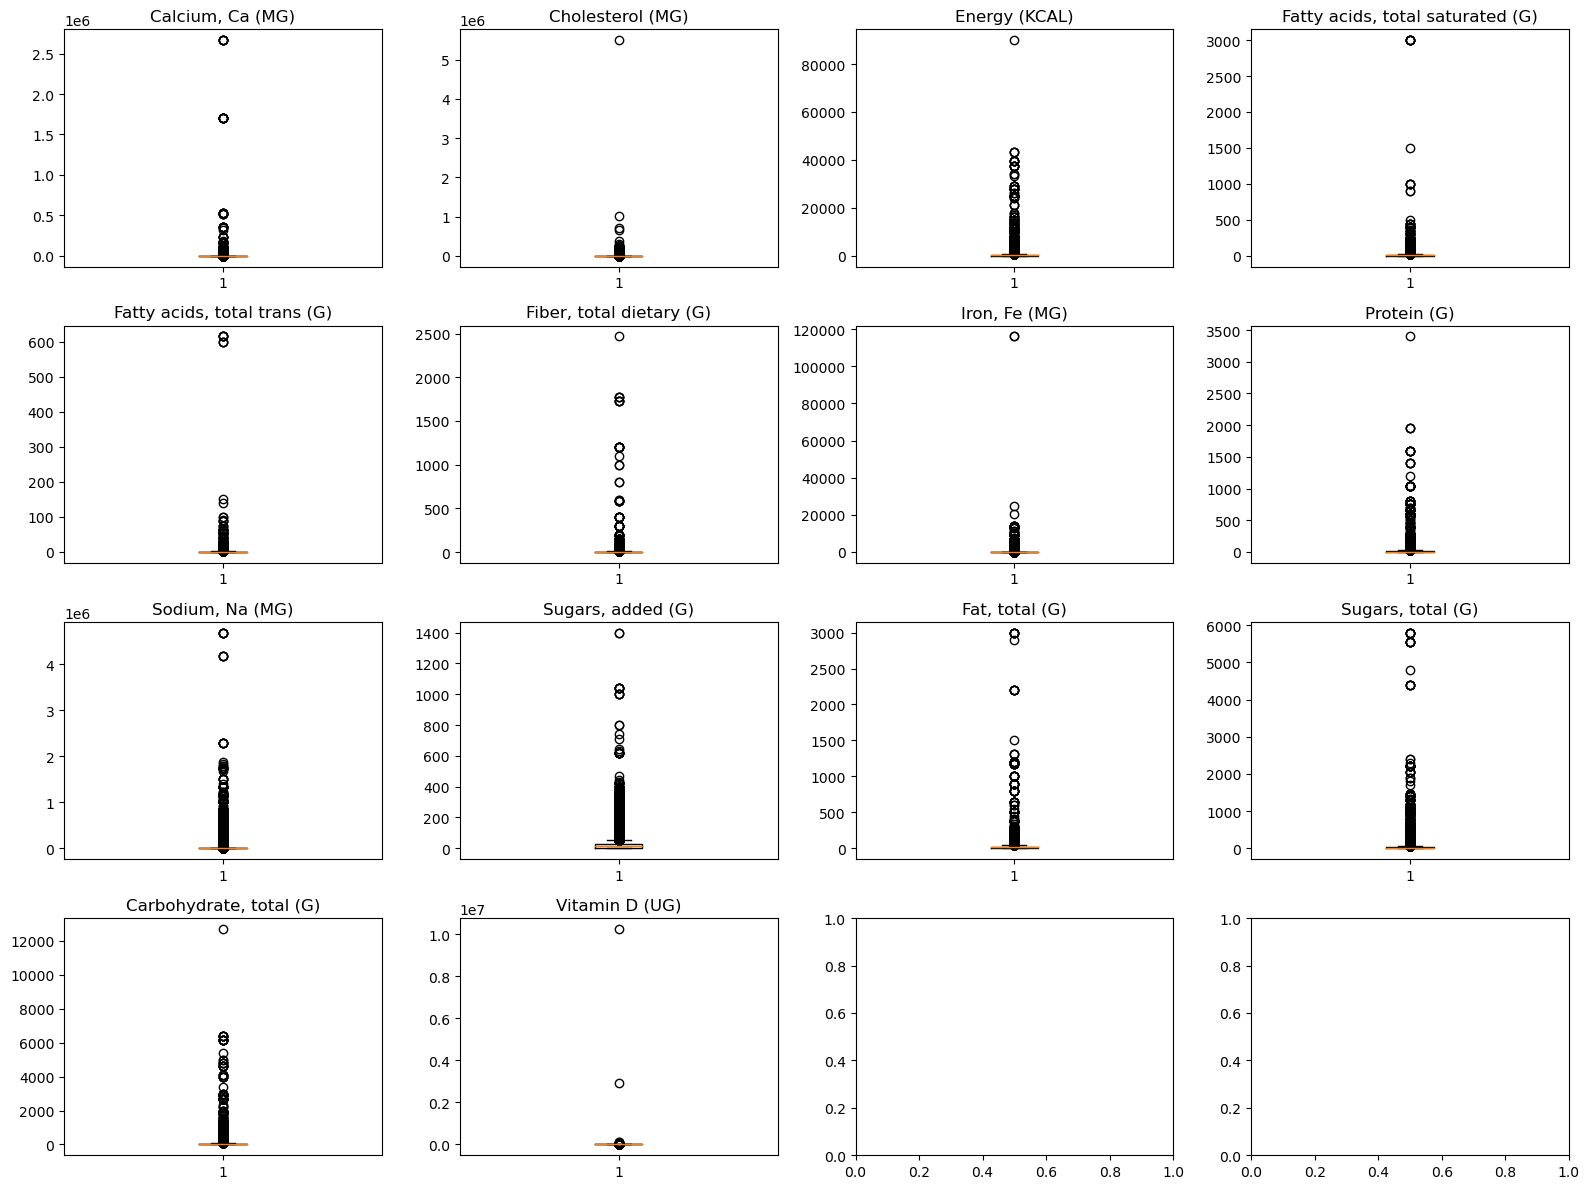

In [37]:
# boxplots of amounts for each nutrient column
fig, ax = plt.subplots(4,4, figsize=(16,12))
axs = ax.ravel()

for i, col in enumerate(unstacked.columns):
    cond = unstacked[col] > 0
    axs[i].boxplot(unstacked.loc[cond, col])
    axs[i].set_title(col)
    
plt.tight_layout()

In [38]:
# some nutrient values are abnormally high for 100g or 100ml portion --> no nutrient should be > 100g
# indicates inaccurate data entries
# eliminate items with nutrient value >= 100g (a food item likely not composed of just a single nutrient)
for col in unstacked.columns:
    if '(G)' in col:
        # bool, indicates rows with values less than 100
        cond = unstacked[col] < 100
    elif '(MG)' in col:
        # bool, indicates rows with values less than 100,000
        cond = unstacked[col] < 1e5
    else:
        continue
    # keep rows that meet condition
    unstacked = unstacked[cond]

In [39]:
# sum of main constituents of food shouldn't exceed 100g, probably sum to less than 100g due to water content
# sum carbohydrates, fats, proteins of each item
cfp = unstacked['Carbohydrate, total (G)'].fillna(0) \
    + unstacked['Fat, total (G)'].fillna(0) \
    + unstacked['Protein (G)'].fillna(0)

print('number of items with abnormally large values (cfp):', np.sum(cfp >= 100))

# drop items with unreasonably large nutrient values
unstacked = unstacked[cfp < 100]

number of items with abnormally large values (cfp): 4002


In [40]:
# using sugar total instead of carb total in sum
sfp = unstacked['Sugars, total (G)'].fillna(0) \
    + unstacked['Fat, total (G)'].fillna(0) \
    + unstacked['Protein (G)'].fillna(0)

print('number of items with abnormally large values (sfp):', np.sum(sfp >= 100))

# drop items with unreasonably large nutrient values, using 'sfp' value
unstacked = unstacked[sfp < 100]

number of items with abnormally large values (sfp): 11


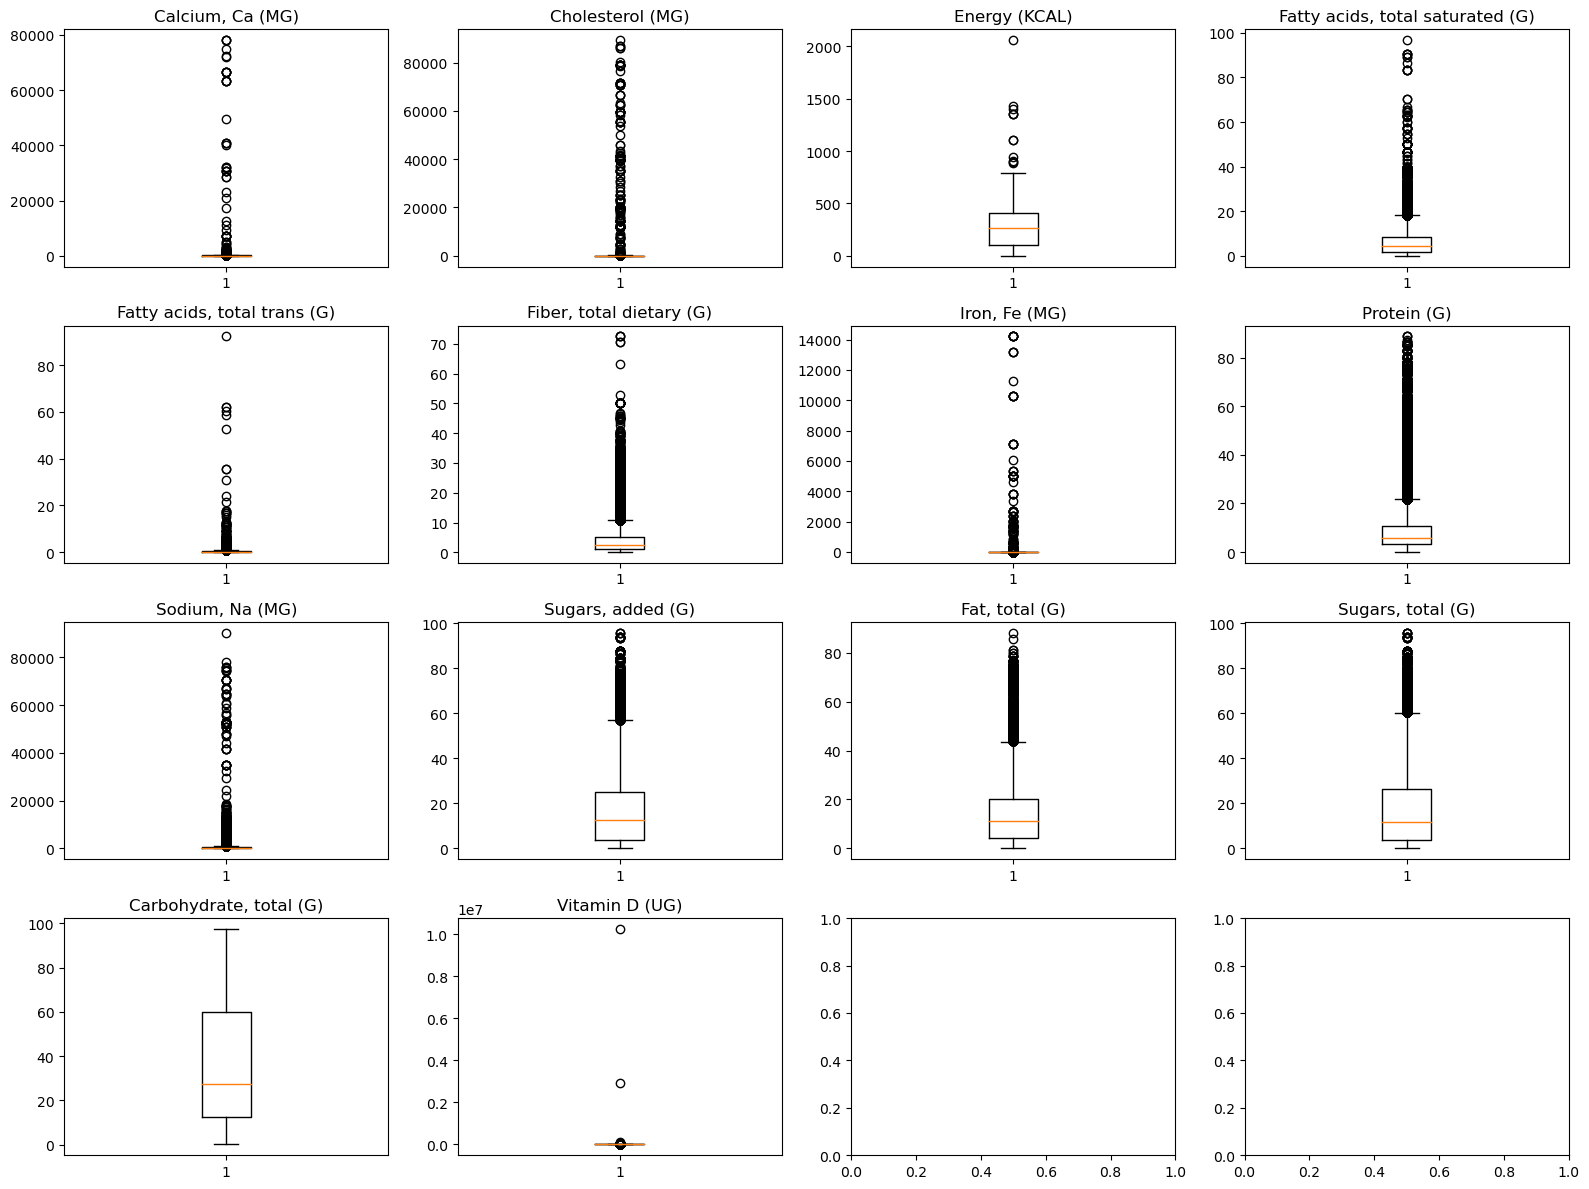

In [41]:
# plot values after dropping items with unreasonably high values
fig, ax = plt.subplots(4,4, figsize=(16,12))
axs = ax.ravel()

for i, col in enumerate(unstacked.columns):
    cond = unstacked[col] > 0
    axs[i].boxplot(unstacked.loc[cond, col])
    axs[i].set_title(col)

plt.tight_layout()

In [42]:
print('shape after dropping rows with unreasonably large values:', unstacked.shape)

shape after dropping rows with unreasonably large values: (255717, 14)


In [43]:
unstacked.reset_index(inplace=True)

In [44]:
unstacked.to_csv('cleaned_food_nutrients.csv', index=False)